In [1]:

import os

import numpy as np
import cv2
from skimage.morphology import dilation, ball


import matplotlib.pyplot as plt
import seaborn as sns

from util import values as v
from util.misc.colors import bcolors as c
from util.data import imaging
from filtering import cardiac_region as cr

# GPU config
from util.data.dataset_ht import HtDataset

Membrane

In [9]:
# specimens = [item for sublist in v.specimens.values() for item in sublist]
# specimens = np.random.choice(specimens, 10)
specimens = ['0806_E5', '0503_E1', '0308_E3', '0806_E6', '0518_E3', '0403_E2']
ht_ds = HtDataset() 

for specimen in specimens:    
    print(f'{c.OKBLUE}Processing specimen:{c.ENDC} {specimen}')

    try:
        # Check if the specimen has the required files
        p_img_raw_mem, _ = ht_ds.read_specimen(specimen, level='Membrane', type='RawImages', verbose=1)
        p_img_raw, _ = ht_ds.read_specimen(specimen, level='Nuclei', type='RawImages')
        p_img_seg, _ = ht_ds.read_specimen(specimen, level='Membrane', type='Segmentation')
        features = ht_ds.get_features(specimen, type='Membrane', verbose=1)

        # Read the images
        img_raw_mem = imaging.read_image(p_img_raw_mem, verbose=1).astype(np.uint8)
        img_raw = imaging.read_image(p_img_raw, verbose=1).astype(np.uint8)
        img_seg = imaging.read_image(p_img_seg, verbose=1)

        # Get the features
        labels, centroids = features['original_labels'], features['centroids']

        count = 0
        for i, label in enumerate(labels):            
            # Get the centroids of the cell
            cen = centroids[i].replace('[', '').replace(']', '').split(',')
            x, y, z = int(cen[0]), int(cen[1]), int(cen[2])
        
            # Crop the cell region + Erode the mask
            margins = cr.get_cell_margins(img_seg, label, ma=0)
            mask = img_seg[
                x-25: x+25, y-25: y+25,
                int(margins[0][2]): int(margins[1][2])
            ]
            mask = np.where(mask == label, 255, 0).astype(np.uint8)
            mask_dilated = dilation(mask, ball(2))
            
            # Remove empty z-slices
            non_empty_slices = [i for i in range(mask.shape[2]) if np.any(mask[..., i])]
            mask = mask[..., non_empty_slices]
            mask_dilated = mask_dilated[..., non_empty_slices]
        
            # Crop the cell region of the raw image
            img_cell = img_raw[
                x-25: x+25, y-25: y+25,
                int(margins[0][2]): int(margins[1][2])
            ]
            img_cell = img_cell[..., non_empty_slices]

            img_mem = img_raw_mem[
                x-25: x+25, y-25: y+25,
                int(margins[0][2]): int(margins[1][2])
            ]
            img_mem = img_mem[..., non_empty_slices]
        
            # Erase the background
            img_cell_no_bg = np.where(mask == 0, 0, img_cell)
            img_cell_no_bg_dilated = np.where(mask_dilated == 0, 0, img_cell)
            
            # IQR Filter over the intensities of the cell
            img_cell_no_bg, intensities, thresh = imaging.iqr_filter(img_cell_no_bg, get_params=True, verbose=0)

            img_cell = img_cell[..., intensities > thresh]
            img_mem = img_mem[..., intensities > thresh]
            img_cell_no_bg_dilated = img_cell_no_bg_dilated[..., intensities > thresh]

            # Merge the images as an 3D RGB image (img_cell and img_mem)
            img_all = np.stack([img_cell_no_bg_dilated, img_mem, np.zeros_like(img_cell)], axis=-1)
        
            # Save the images
            img_cell_no_bg = img_cell_no_bg.astype(np.uint8)
            if img_cell_no_bg.shape[2] > 0:
                # for z in range(img_cell_no_bg.shape[2]):
                #     cv2.imshow('Cell', img_cell_no_bg[..., z])
                #     cv2.imshow('Cell_all', img_all[..., z, :])
                #     cv2.waitKey(0)
                #     cv2.destroyAllWindows()
                # print(img_cell_no_bg.shape)
                # print(img_all.shape)
                count += 1
                imaging.save_prediction(
                    img_cell_no_bg,
                    v.data_path + 'CellDivision/images_unlabeled/' + f'{specimen}_{int(label)}.tif',
                    axes='XYZ',
                    verbose=0
                )
                imaging.save_prediction(
                    img_all,
                    v.data_path + 'CellDivision/images_unlabeled_bg/' + f'{specimen}_{int(label)}.tif',
                    axes='XYZC',
                    verbose=0
                )
        print(f'\t{c.BOLD}Saved {count} cells{c.ENDC}')
        count = 0

    except Exception as e:
        import traceback
        print(f'{c.FAIL}Error:{c.ENDC} {e}')
        traceback.print_exc()
        continue


Processing specimen: 0806_E5
	Found: 20190806_E5_mGFP_decon_0.5.nii.gz
	Found: 20190806_E5_cell_properties_radiomics_Membrane_splanchnic.csv
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/RawImages/Membrane/20190806_E5_mGFP_decon_0.5.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/RawImages/Nuclei/20190806_E5_DAPI_decon_0.5.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/Segmentation/Membrane/20190806_E5_mask.nii.gz
	Saved 733 cells
Processing specimen: 0503_E1
	Found: 20190503_E1_mGFP_decon_0.5.nii.gz
	Found: 20190503_E1_cell_properties_radiomics_Membrane_splanchnic.csv
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr2/RawImages/Membrane/20190503_E1_mGFP_decon_0.5.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr2/Raw

Traceback (most recent call last):
  File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'original_labels'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipykernel_3733252/3290627585.py", line 22, in <module>
    labels, centroids = features['original_labels'], features['centroids']
  File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/pandas/core/frame.py", line 4102, in __getitem__
    indexer = self.

	Found: 20190518_E3_cell_properties_radiomics_Membrane_myocardium.csv
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr5/RawImages/Membrane/20190518_E3_mGFP_decon_0.5.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr5/RawImages/Nuclei/20190518_E3_DAPI_decon_0.5.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr5/Segmentation/Membrane/20190518_E3_mask.nii.gz
	Saved 3412 cells
Processing specimen: 0403_E2
	Found: 20190403_E2_mGFP_decon_0.5.nii.gz
	Found: 20190403_E2_cell_properties_radiomics_Membrane_splanchnic.csv
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr7/RawImages/Membrane/20190403_E2_mGFP_decon_0.5.nii.gz
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr7/RawImages/Nuclei/20190403_E2_DAPI_decon_0.5.nii.gz
Reading NIfTI: /run/us

/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
Traceback (most recent call last):
  File "/tmp/ipykernel_3733252/3290627585.py", line 62, in <module>
    img_cell_no_bg, intensities, thresh = imaging.iqr_filter(img_cell_no_bg, get_params=True, verbose=0)
  File "/home/imarcoss/ht_morphogenesis/auxiliary/data/imaging.py", line 263, in iqr_filter
    q1 = np.percentile(intensities, 35)
  File "<__array_function__ internals>", line 180, in percentile
  File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/numpy/lib/function_base.py", line 4166, in percentile
    return _quantile_unchecked(
  File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/numpy/lib/function_base.py", line 4424, in _quantile_unchecked
    r, k = _ureduce(a,
  File "/home/imarcoss/mambaforge/envs/py310ml/lib/python3.10/site-packages/numpy/l

In [10]:
def plot_global_intensity_hist(stacks, bins=100):
    all_intensities = []
    for i, stack in enumerate(stacks):
        stack = stack * 255
        stack = stack.astype(np.uint8)
        all_intensities.append(np.mean(stack.flatten()))
    
    plt.figure(figsize=(10, 5))
    sns.histplot(
        all_intensities, kde=True, bins=bins, 
        color='blue', alpha=0.7
    )
    plt.title('Histogram of intensities')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.show()

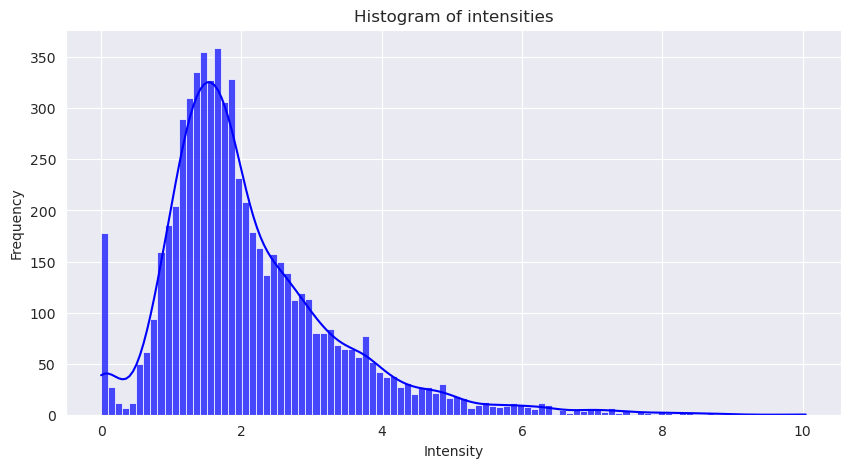

In [11]:
from util.data.dataset_unlabeled import UnlabeledDataset


data_path = v.data_path + 'CellDivision/images_unlabeled/'
unlabeled_ds = UnlabeledDataset(data_path, batch_size=1)

plot_global_intensity_hist(unlabeled_ds)

In [12]:
data_path = v.data_path + 'CellDivision/images_unlabeled/'
data_path_bg = v.data_path + 'CellDivision/images_unlabeled_bg/'
unlabeled_ds = UnlabeledDataset(data_path, batch_size=1)

In [14]:
def filter_intensity(stacks, threshold=0.3):
    removed = 0
    
    for i, stack in enumerate(stacks):
        stack = stack * 255
        stack = stack.astype(np.uint8)
        if np.mean(stack.flatten()) < threshold:
            removed += 1
            
            img_path = unlabeled_ds.img_names[i]
            os.remove(img_path)
            
    print(f'Removed {removed} images')
    
filter_intensity(unlabeled_ds, threshold=0.4)

Removed 223 images


Nuclei

In [2]:
# specimens = [item for sublist in v.specimens.values() for item in sublist]
# specimens = np.random.choice(specimens, 10)
specimens = ['0808_E5', '0503_E1', '0308_E3', '0806_E6', '0518_E3', '0403_E2']

ht_ds = HtDataset() 

for specimen in specimens:    
    print(f'{c.OKBLUE}Processing specimen:{c.ENDC} {specimen}')

    try:
        # Check if the specimen has the required files
        p_img_raw_mem, _ = ht_ds.read_specimen(specimen, level='Membrane', type='RawImages')
        p_img_raw, _ = ht_ds.read_specimen(specimen, level='Nuclei', type='RawImages')
        p_img_seg, _ = ht_ds.read_specimen(specimen, level='Nuclei', type='Segmentation')
        features = ht_ds.get_features(specimen, type='Nuclei')

        # Read the images
        img_raw_mem = imaging.read_image(p_img_raw_mem, verbose=1).astype(np.uint8)
        img_raw = imaging.read_image(p_img_raw, verbose=1).astype(np.uint8)
        img_seg = imaging.read_image(p_img_seg, verbose=1)

        # Get the features
        labels, centroids = features['original_labels'], features['centroids']

        count = 0
        for i, label in enumerate(labels):
            # Get the centroids of the cell
            cen = centroids[i].replace('[', '').replace(']', '').split(',')
            x, y, z = int(cen[0]), int(cen[1]), int(cen[2])
        
            # Crop the cell region + Erode the mask
            mask = img_seg[x-25: x+25, y-25: y+25, z-10: z+10]
            mask = np.where(mask == label, 255, 0).astype(np.uint8)
            mask = np.swapaxes(np.swapaxes([
                cv2.erode(mask[..., z], np.ones((1, 1)), iterations=1) 
                for z in range(mask.shape[2])
            ], 0, 1), 1, 2)
            
            # Remove empty z-slices
            non_empty_slices = [i for i in range(mask.shape[2]) if np.any(mask[..., i])]
            mask = mask[..., non_empty_slices]
        
            # Crop the cell region of the raw image
            img_cell = img_raw[x-25: x+25, y-25: y+25, z-10: z+10]
            img_cell = img_cell[..., non_empty_slices]

            img_mem = img_raw_mem[x-25: x+25, y-25: y+25, z-10: z+10]
            img_mem = img_mem[..., non_empty_slices]
        
            # Erase the background
            img_cell_no_bg = np.where(mask == 0, 0, img_cell)
            
            # IQR Filter over the intensities of the cell
            img_cell_no_bg, intensities, thresh = imaging.iqr_filter(img_cell_no_bg, get_params=True, verbose=0)

            img_cell = img_cell[..., intensities > thresh]
            img_mem = img_mem[..., intensities > thresh]

            # Merge the images as an 3D RGB image (img_cell and img_mem)
            img_all = np.stack([img_cell, img_mem, np.zeros_like(img_cell)], axis=-1)
        
            # Save the images
            img_cell_no_bg = img_cell_no_bg.astype(np.uint8)
            if img_cell_no_bg.shape[2] > 0:
                count += 1
                imaging.save_prediction(
                    img_cell_no_bg,
                    v.data_path + 'CellDivision/images_unlabeled/' + f'{specimen}_{int(label)}.tif',
                    verbose=0
                )
                imaging.save_prediction(
                    img_all,
                    v.data_path + 'CellDivision/images_unlabeled_bg/' + f'{specimen}_{int(label)}.tif',
                    verbose=0
                )
        count = 0
        print(f'\t{c.BOLD}Saved {count} cells{c.ENDC}')

    except Exception as e:
        print(f'{c.FAIL}Error:{c.ENDC} {e}')
        continue


Processing specimen: 0806_E5
Error: No specimen found: 0806_E5
Processing specimen: 0504_E1
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/RawImages/Nuclei/20190504_E1_DAPI_decon_0.5.nii.gz
Reading TIFF: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/Segmentation/Nuclei/20190504_E1_Fernando.tif
	Saved 0 cells
Processing specimen: 0208_E2
Error: No specimen found: 0208_E2
Processing specimen: 0521_E4
Error: No specimen found: 0521_E4
Processing specimen: 0521_E2
Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/RawImages/Nuclei/20190521_E2_DAPI_decon_0.5.nii.gz
Reading TIFF: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/Segmentation/Nuclei/20190521_E2_Fernando.tif
	Saved 0 cells
Processing specimen: 0516_E2
Error: No specimen found: 0516_E2
Processing specimen: 0503_E1
Error: No specimen found: 0503_E1
Processing 

Histogram of intensities

In [12]:
def plot_global_intensity_hist(stacks, bins=100):
    all_intensities = []
    for i, stack in enumerate(stacks):
        stack = stack * 255
        stack = stack.astype(np.uint8)
        all_intensities.append(np.mean(stack.flatten()))
    
    plt.figure(figsize=(10, 5))
    sns.histplot(
        all_intensities, kde=True, bins=bins, 
        color='blue', alpha=0.7
    )
    plt.title('Histogram of intensities')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.show()

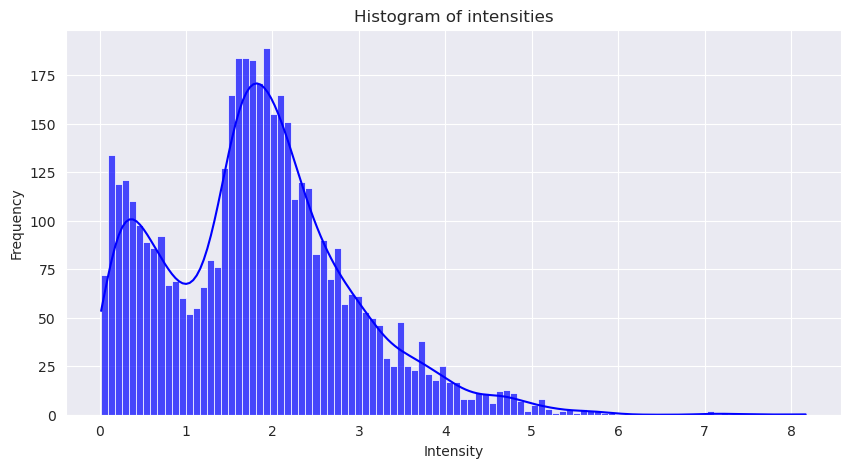

In [13]:
from util.data.dataset_unlabeled import UnlabeledDataset


data_path = v.data_path + 'CellDivision/images_unlabeled/'
unlabeled_ds = UnlabeledDataset(data_path, batch_size=1)

plot_global_intensity_hist(unlabeled_ds)

Filter the images based on the intensity

In [3]:
data_path = v.data_path + 'CellDivision/images_unlabeled/'
unlabeled_ds = UnlabeledDataset(data_path, batch_size=1)

In [4]:
def filter_intensity(stacks, threshold=0.3):
    removed = 0
    
    for i, (stack, path) in enumerate(stacks):
        stack = stack * 255
        stack = stack.astype(np.uint8)
        if np.mean(stack.flatten()) < threshold:
            os.remove(path[0])
            removed += 1
            
    print(f'Removed {removed} images')
    
filter_intensity(unlabeled_ds)

Removed 1683 images
